## Strategy optimizer

this is traditional strategy optimizer which enough to handle most cases of basic trading.

### Directly Optimization Optimizer

In [ ]:
# input -> strategy(input, hyper) -> output
# input hyper -> result by input in loss function -> output
# eg. reward = a * 2 + b * 5 + c * 3 and a + b + c = 10. ideal result is [2, 5, 3] 
# output = [theta1, theta2, theta3]
# loss = output1...3 -> loss

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.a = nn.Linear(hidden_size, 1)
        self.b = nn.Linear(hidden_size, 1)
        self.c = nn.Linear(hidden_size, 1)

        self.a_slope = nn.Parameter(torch.tensor(1.0))
        self.a_intercept = nn.Parameter(torch.tensor(0.0))
        self.b_slope = nn.Parameter(torch.tensor(1.0))
        self.b_intercept = nn.Parameter(torch.tensor(0.0))
        self.c_slope = nn.Parameter(torch.tensor(1.0))
        self.c_intercept = nn.Parameter(torch.tensor(0.0))
        self.relu= nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        # ao, bo, co = self.a(x), self.b(x), self.c(x)
        # return ao, bo, co
        a_base, b_base, c_base = x[:, 0], x[:, 1], x[:, 2]
        a = self.a_slope * a_base + self.a_intercept
        b = self.b_slope * b_base + self.b_intercept
        c = self.c_slope * c_base + self.c_intercept
        return a, b, c

# Objective function
def loss1(a, b, c):
    return -(a * 2 + b * 5 + c * 3).mean()

def loss2(a, b, c):
    return (1000. * (a + b + c - 10) ** 2).mean()

def loss3(a, b, c):
    penalty = torch.relu(-a) + torch.relu(-b) + torch.relu(-c)
    return penalty.mean() * 1000.  # Large penalty to enforce non-negativity

# Initialize the model
model = SimpleNet(1, 128)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    x_dummy = torch.zeros(100, 1)
    a, b, c = model(torch.tensor(x_dummy))
    #  = outputs[0][0], outputs[0][1], outputs[0][2]
    loss = loss1(a, b, c) + loss2(a, b, c) + loss3(a, b, c)
    loss.backward()
    optimizer.step()
    
    # if (epoch + 1) % 100 == 0:
        # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, a: {a.item():.4f}, b: {b.item():.4f}, c: {c.item():.4f}')

# Final optimized values
a_opt, b_opt, c_opt = model(torch.tensor([[0.0]]))
print(f'Optimized values - a: {a_opt.item():.4f}, b: {b_opt.item():.4f}, c: {c_opt.item():.4f}')


/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_31004/526140221.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a, b, c = model(torch.tensor(x_dummy))


Optimized values - a: 3.8143, b: 6.0970, c: 0.0905


In [86]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the encoder-decoder model
class EncoderDecoderModel(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(EncoderDecoderModel, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3)  # Output 3 values for a, b, and c
        )

    def forward(self, x):
        latent = self.encoder(x)
        outputs = self.decoder(latent)
        a, b, c = outputs[:, 0], outputs[:, 1], outputs[:, 2]
        return a, b, c

# Objective function
def loss1(a, b, c):
    return -(a * 2 + b * 5 + c * 3).mean()

def loss2(a, b, c):
    return ((a + b + c - 10) ** 2).mean() * 1000.

def loss3(a, b, c):
    penalty = torch.relu(-a) + torch.relu(-b) + torch.relu(-c)
    return penalty.mean() * 1000.  # Large penalty to enforce non-negativity

# Initialize the model
input_size = 1  # Dummy input size, since we're directly optimizing a, b, and c
hidden_size = 10
latent_size = 5
model = EncoderDecoderModel(input_size, hidden_size, latent_size)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
batch_size = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Dummy input for the batch (all ones to simulate intercept learning)
    x_dummy = torch.ones(batch_size, input_size)
    
    # Forward pass
    a, b, c = model(x_dummy)
    
    # Compute losses
    obj_loss = loss1(a, b, c)
    const_loss = loss2(a, b, c)
    non_neg_penalty = loss3(a, b, c)
    
    # Combine losses with weights
    combined_loss = obj_loss + const_loss + non_neg_penalty
    combined_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Combined Loss: {combined_loss.item():.4f}, Objective Loss: {obj_loss.item():.4f}, Constraint Loss: {const_loss.item():.4f}, Penalty: {non_neg_penalty.item():.4f}, a: {a.mean().item():.4f}, b: {b.mean().item():.4f}, c: {c.mean().item():.4f}')

# Final optimized values (using a single input to get final values)
x_dummy = torch.ones(1, input_size)  # Single input to get final values
a_opt, b_opt, c_opt = model(x_dummy)
print(f'Optimized values - a: {a_opt.item():.4f}, b: {b_opt.item():.4f}, c: {c_opt.item():.4f}')


Epoch [100/100], Combined Loss: -35.9946, Objective Loss: -36.1386, Constraint Loss: 0.1440, Penalty: 0.0000, a: 1.2982, b: 3.7364, c: 4.9534
Optimized values - a: 1.3030, b: 3.7480, c: 4.9679


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the encoder-decoder model
class EncoderDecoderModel(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(EncoderDecoderModel, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3)  # Output 3 values for a, b, and c
        )

    def forward(self, x):
        latent = self.encoder(x)
        outputs = self.decoder(latent)
        a, b, c = outputs[:, 0], outputs[:, 1], outputs[:, 2]
        return a, b, c

# Objective function
def loss1(a, b, c):
    return -(a * 2 + b * 5 + c * 3).mean()

def loss2(a, b, c):
    return ((a + b + c - 10) ** 2).mean() * 1000.

def loss3(a, b, c):
    penalty = torch.relu(-a) + torch.relu(-b) + torch.relu(-c)
    return penalty.mean() * 1000.  # Large penalty to enforce non-negativity

# Initialize the model
input_size = 1  # Dummy input size, since we're directly optimizing a, b, and c
hidden_size = 10
latent_size = 5
model = EncoderDecoderModel(input_size, hidden_size, latent_size)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000
batch_size = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Dummy input for the batch (all ones to simulate intercept learning)
    x_dummy = torch.ones(batch_size, input_size)
    
    # Forward pass
    a, b, c = model(x_dummy)
    
    # Compute losses
    obj_loss = loss1(a, b, c)
    const_loss = loss2(a, b, c)
    non_neg_penalty = loss3(a, b, c)
    
    # Combine losses with weights
    combined_loss = obj_loss + const_loss + non_neg_penalty
    combined_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Combined Loss: {combined_loss.item():.4f}, Objective Loss: {obj_loss.item():.4f}, Constraint Loss: {const_loss.item():.4f}, Penalty: {non_neg_penalty.item():.4f}, a: {a.mean().item():.4f}, b: {b.mean().item():.4f}, c: {c.mean().item():.4f}')

# Final optimized values (using a single input to get final values)
x_dummy = torch.ones(1, input_size)  # Single input to get final values
a_opt, b_opt, c_opt = model(x_dummy)
print(f'Optimized values - a: {a_opt.item():.4f}, b: {b_opt.item():.4f}, c: {c_opt.item():.4f}')


Epoch [100/10000], Combined Loss: -23.5286, Objective Loss: -34.0993, Constraint Loss: 10.5707, Penalty: 0.0000, a: 3.0835, b: 3.4372, c: 3.5821
Epoch [200/10000], Combined Loss: -33.7676, Objective Loss: -33.7729, Constraint Loss: 0.0054, Penalty: 0.0000, a: 3.0488, b: 3.4074, c: 3.5461
Epoch [300/10000], Combined Loss: -33.7813, Objective Loss: -33.7841, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0447, b: 3.4119, c: 3.5450
Epoch [400/10000], Combined Loss: -33.7975, Objective Loss: -33.8003, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0401, b: 3.4177, c: 3.5439
Epoch [500/10000], Combined Loss: -33.8164, Objective Loss: -33.8192, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0346, b: 3.4244, c: 3.5427
Epoch [600/10000], Combined Loss: -33.8378, Objective Loss: -33.8406, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0284, b: 3.4320, c: 3.5413
Epoch [700/10000], Combined Loss: -33.8618, Objective Loss: -33.8646, Constraint Loss: 0.0028, Penalty: 0.0000, a: 3.0214, b: 3.4405, c

### Regression Optimization

Epoch [100/1000], Loss: 0.1263
Epoch [200/1000], Loss: 0.0249
Epoch [300/1000], Loss: 0.0082
Epoch [400/1000], Loss: 0.0032
Epoch [500/1000], Loss: 0.0049
Epoch [600/1000], Loss: 0.0018
Epoch [700/1000], Loss: 0.0046
Epoch [800/1000], Loss: 0.0015
Epoch [900/1000], Loss: 0.0015
Epoch [1000/1000], Loss: 0.0019


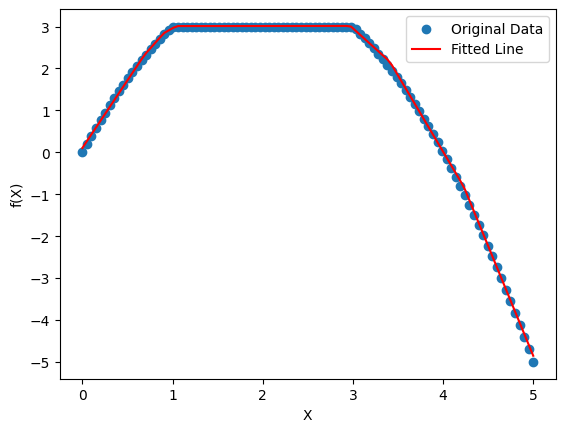

Optimal value: 3.0144801139831543 at X: 2.929292917251587


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate data for the optimization problem
X = np.linspace(0, 5, 100).reshape(-1, 1)  # Features
y = -X**2 + 4*X  # Labels (objective function values)
y = np.where(y > 3, 3, y)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define a simple neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = 1
hidden_size = 10
model = NeuralNetwork(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predicted = model(X_tensor).numpy()

# Plot the results
plt.scatter(X, y, label='Original Data')
plt.plot(X, predicted, label='Fitted Line', color='red')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()
plt.show()

# Find the optimal solution
X_new = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_new)
optimal_value, optimal_index = torch.max(predictions, 0)
optimal_x = X_new[optimal_index]

print(f'Optimal value: {optimal_value.item()} at X: {optimal_x.item()}')


In [65]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32)
        self.targets = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)  # No sigmoid here
        return x


data = {
    'feature1': [1.0, 2.0, 3.0, 4.0],
    'feature2': [5.0, 6.0, 7.0, 8.0],
    'feature3': [9.0, 10.0, 11.0, 12.0],
    'target': [0.0, 0.2, 0.4, 0.6]
}

df = pd.DataFrame(data)

# Split into features and targets
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Create dataset and dataloader
batch_size = 2
dataset = CustomDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

import torch.optim as optim
from sklearn.metrics import mean_squared_error

# Instantiate the model, define the loss function and the optimizer
input_size = X.shape[1]
hidden_size = 5
model = NeuralNetwork(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_features, batch_targets in dataloader:
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_features)
        scaled_outputs = torch.sigmoid(outputs)  # Scale the output to [0, 1] here
        loss = criterion(scaled_outputs, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

# Evaluation
model.eval()
val_dataset = CustomDataset(X, y)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

predicted_values = []
target_values = []

with torch.no_grad():
    for batch_features, batch_targets in val_dataloader:
        outputs = model(batch_features)
        scaled_outputs = torch.sigmoid(outputs)  # Scale the output to [0, 1] here
        predicted_values.extend(scaled_outputs.numpy())
        target_values.extend(batch_targets.numpy())

# Compute MSE
predicted_values = torch.tensor(predicted_values).view(-1)
target_values = torch.tensor(target_values).view(-1)

mse = mean_squared_error(target_values, predicted_values)
print(f'Mean Squared Error (MSE): {mse:.4f}')


Epoch [1/10], Loss: 0.0720
Epoch [2/10], Loss: 0.0643
Epoch [3/10], Loss: 0.0620
Epoch [4/10], Loss: 0.0593
Epoch [5/10], Loss: 0.0604
Epoch [6/10], Loss: 0.0588
Epoch [7/10], Loss: 0.0586
Epoch [8/10], Loss: 0.0592
Epoch [9/10], Loss: 0.0587
Epoch [10/10], Loss: 0.0577
Mean Squared Error (MSE): 0.0571
